In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [2]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [12]:
CNSTM_397 = sc.read(inpath+"CNSTM_397.h5ad")
CNSTM_394 = sc.read(inpath+"CNSTM_394.h5ad")
CNSTM_390 = sc.read(inpath+"CNSTM_390.h5ad")
CNSTM_379 = sc.read(inpath+"CNSTM_379.h5ad")
CNSTM_375 = sc.read(inpath+"CNSTM_375.h5ad")
CNSTM_397 = sc.read(inpath+"CNSTM_397.h5ad")
CNSTM_096 = sc.read(inpath+"CNSTM_096.h5ad")
CNSTM_068 = sc.read(inpath+"CNSTM_068.h5ad")

# Read Metadata

In [13]:
metadata = pd.read_excel('Metadata2.xlsx')

In [14]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

# Fix Metadata 

In [15]:
def fixmeta(metadata,sample,adata):
    tmp1 = metadata.loc[metadata['SampleID'] == sample].loc[metadata.loc[metadata['SampleID'] == sample].index.repeat(adata.shape[0])]
    tmp1.reset_index(drop=True,inplace=True)
    tmp1.set_index( sample+"_"  + tmp1.index.astype(str),inplace=True) 
    adata.obs = tmp1
    return adata

In [16]:
CNSTM_397 = fixmeta(metadata,"CNSTM_397",CNSTM_397)
CNSTM_394 = fixmeta(metadata,"CNSTM_394",CNSTM_394)
CNSTM_390 = fixmeta(metadata,"CNSTM_390",CNSTM_390)
CNSTM_379 = fixmeta(metadata,"CNSTM_379",CNSTM_379)
CNSTM_375 = fixmeta(metadata,"CNSTM_375",CNSTM_375)
CNSTM_397 = fixmeta(metadata,"CNSTM_397",CNSTM_397)
CNSTM_096 = fixmeta(metadata,"CNSTM_096",CNSTM_096)
CNSTM_068 = fixmeta(metadata,"CNSTM_068",CNSTM_068)

# Concatenate 

In [17]:
CNSTM_397

AnnData object with n_obs × n_vars = 10842 × 33538
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET'
    var: 'gene_ids', 'feature_types'

In [18]:
CNSTM_397.var_names_make_unique()
CNSTM_394.var_names_make_unique()
CNSTM_390.var_names_make_unique()
CNSTM_379.var_names_make_unique()
CNSTM_375.var_names_make_unique()
CNSTM_397.var_names_make_unique()
CNSTM_096.var_names_make_unique()
CNSTM_068.var_names_make_unique()

In [19]:
adata = CNSTM_397.concatenate(CNSTM_394,CNSTM_390,CNSTM_379,CNSTM_375,CNSTM_096,CNSTM_068,
                         index_unique=None)

In [22]:
#del(CNSTM_068,CNSTM_096,CNSTM_390,CNSTM_379,CNSTM_375,CNSTM_397,CNSTM_096,CNSTM_068)

In [23]:
print(adata.obs['SampleID'].value_counts())
adata

CNSTM_096    31147
CNSTM_390    29470
CNSTM_068    28709
CNSTM_375    26684
CNSTM_397    10842
CNSTM_394    10627
CNSTM_379     8732
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 146211 × 32213
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-0-5', 'gene_ids-1-5', 'gene_ids-2-5', 'gene_ids-3-5', 'gene_ids-6'

In [24]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [25]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [26]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [27]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [28]:
adata

AnnData object with n_obs × n_vars = 146211 × 32213
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-0-5', 'gene_ids-1-5', 'gene_ids-2-5', 'gene_ids-3-5', 'gene_ids-6', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


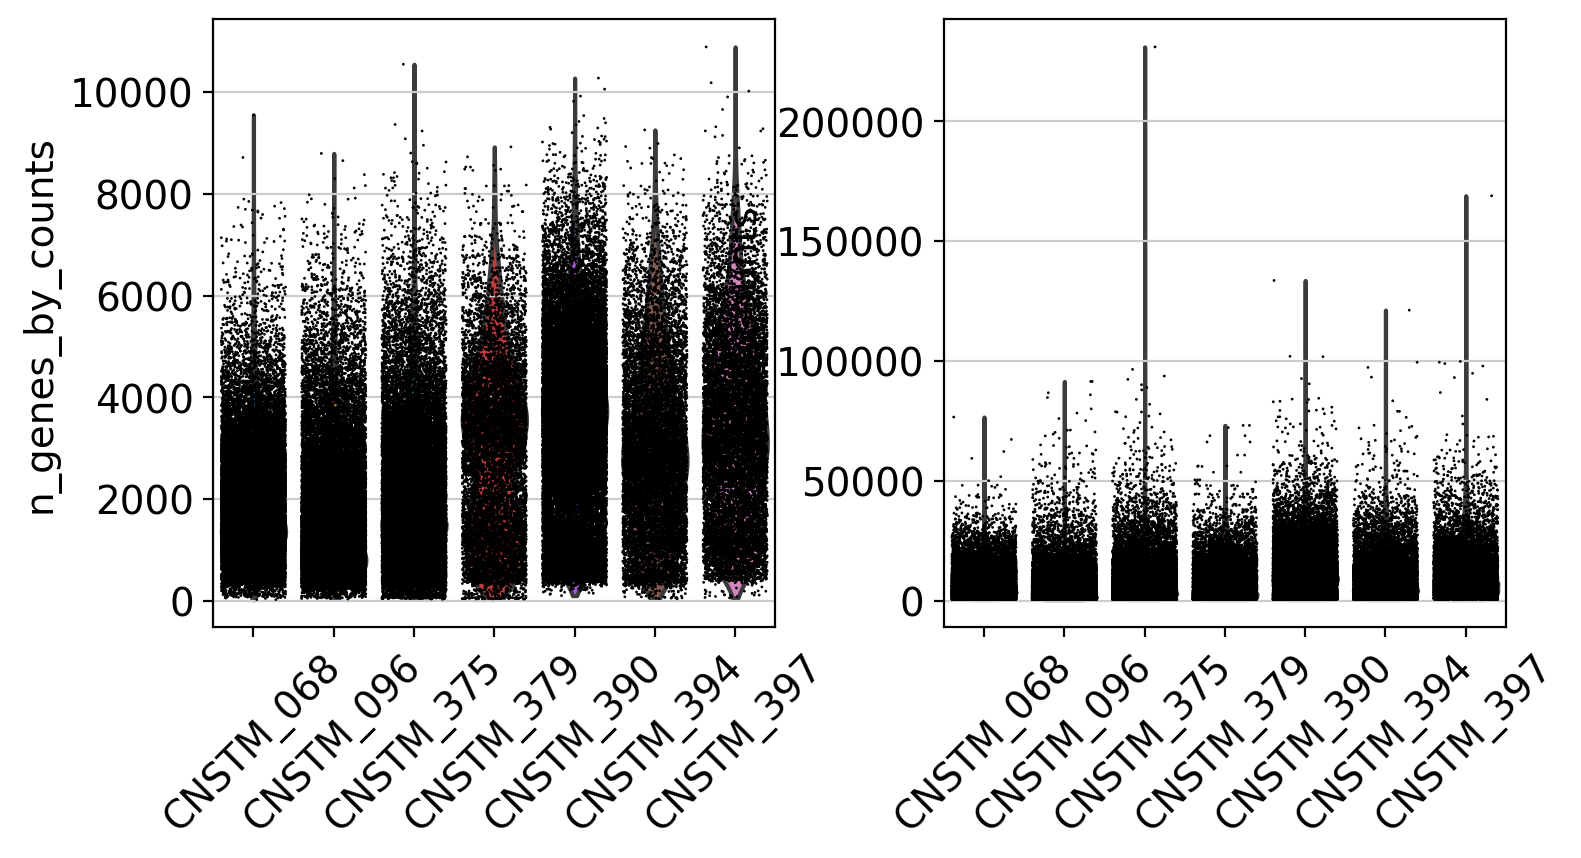

In [29]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

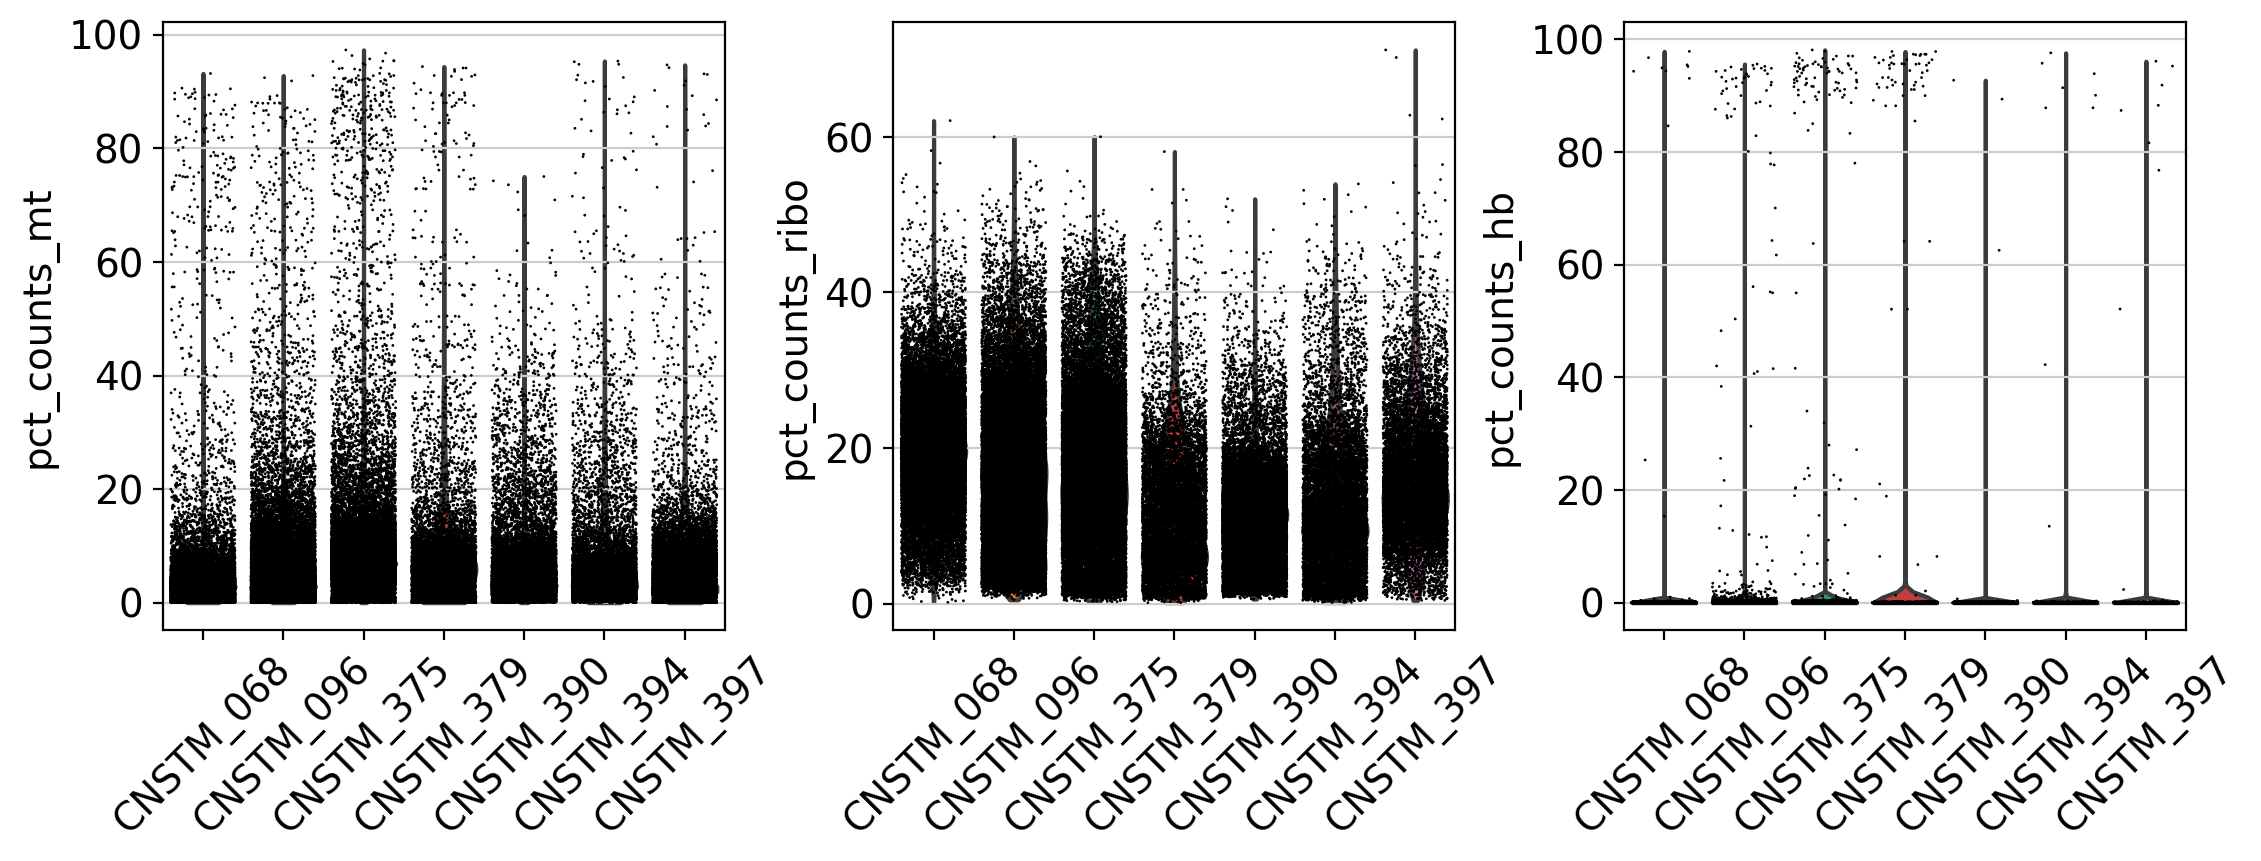

In [30]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

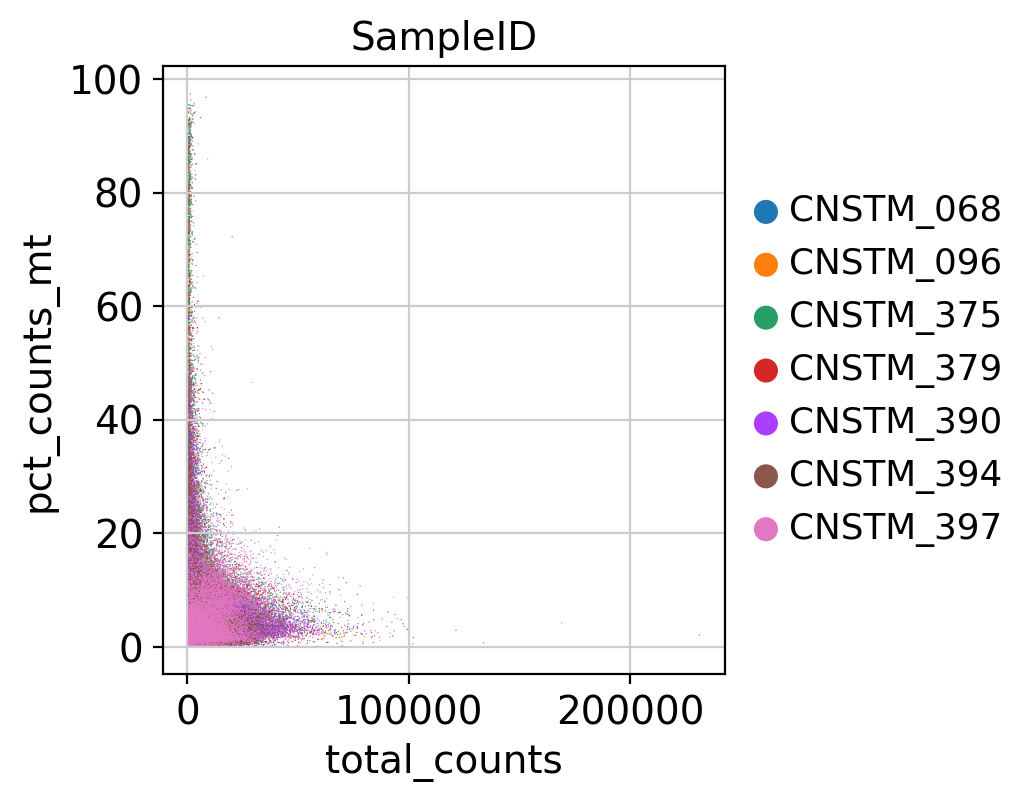

In [31]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [32]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

145311 27298


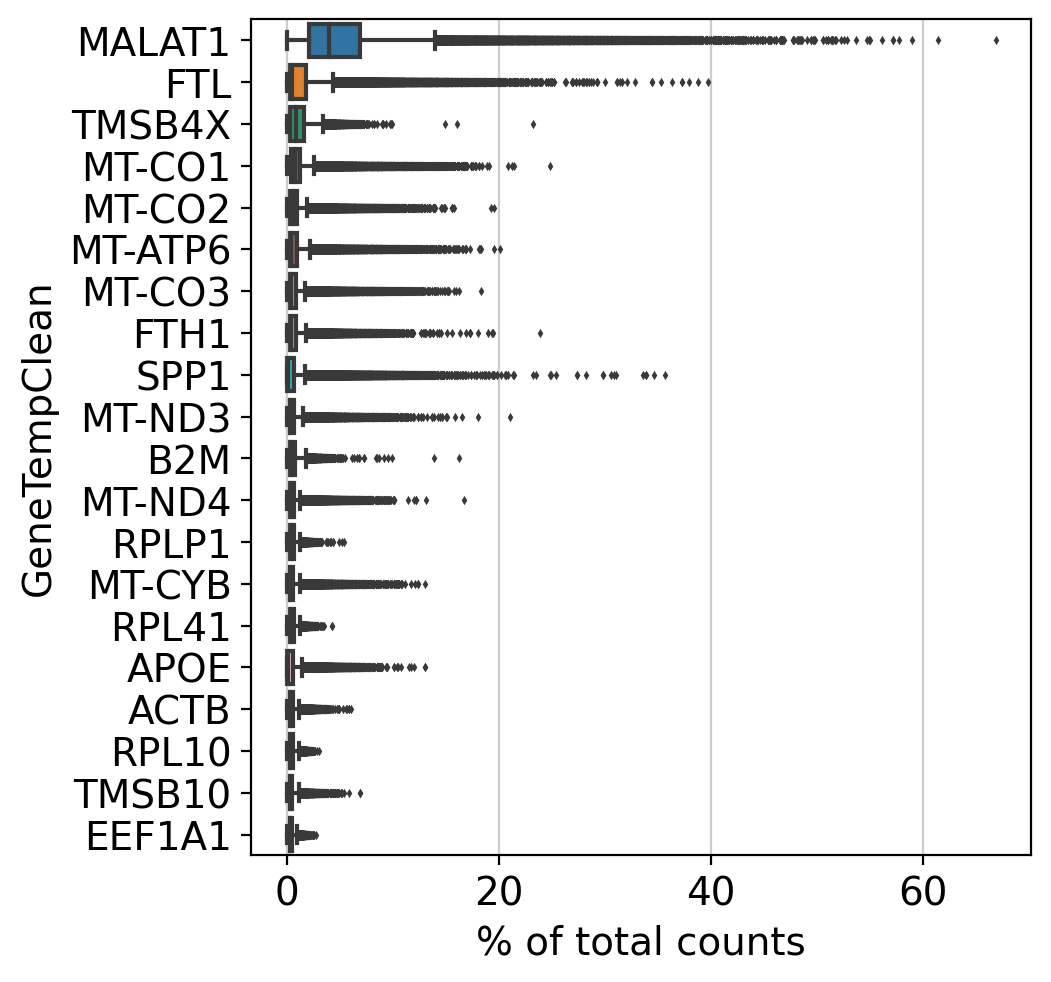

In [33]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [34]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 2, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 137840


# Plot filtered QC

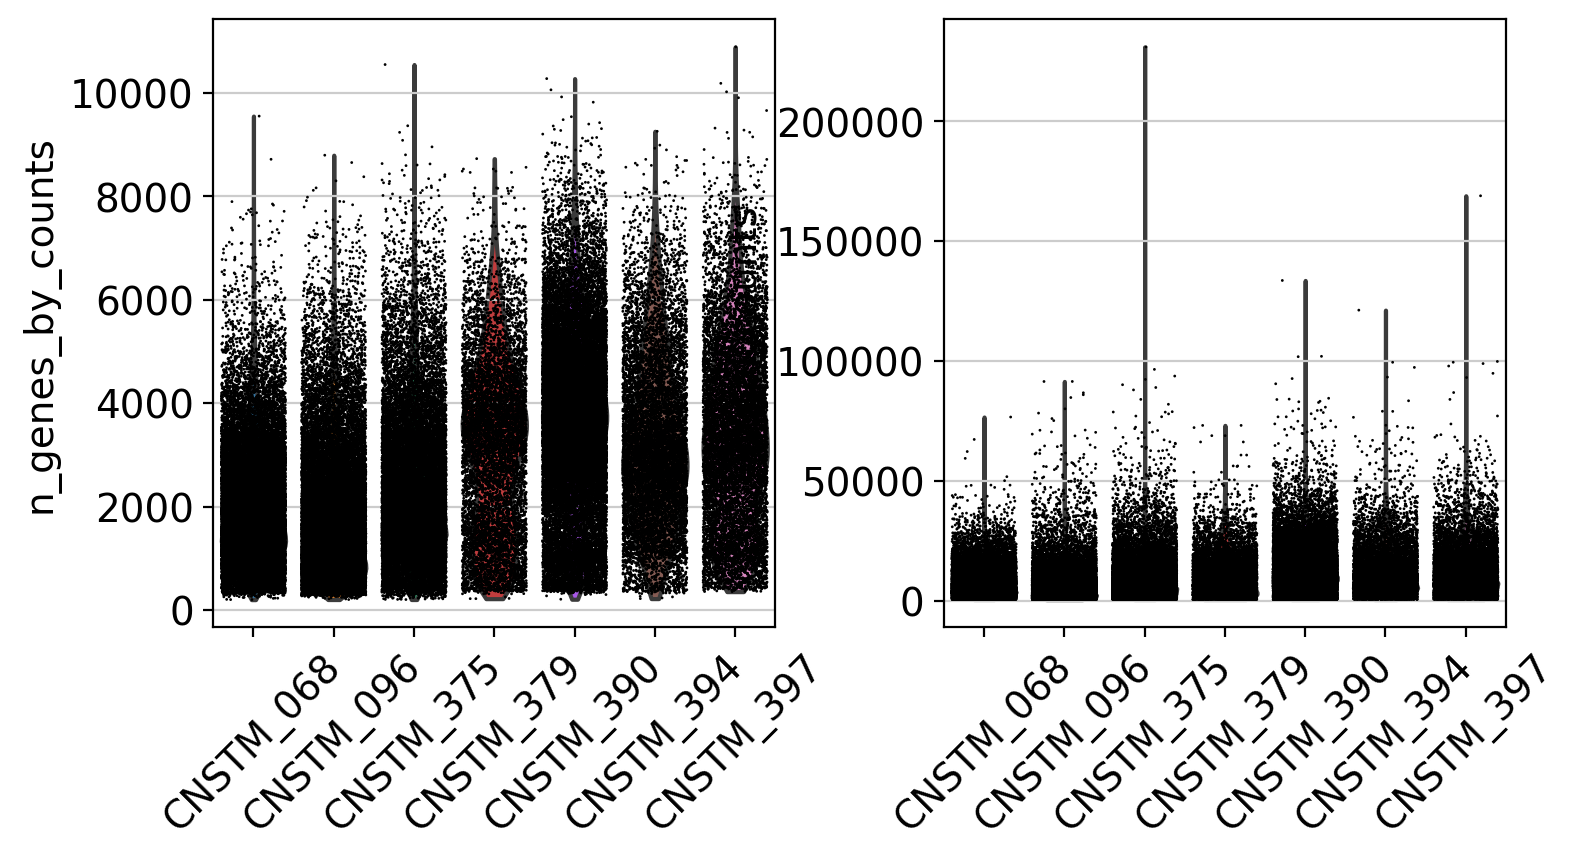

In [35]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

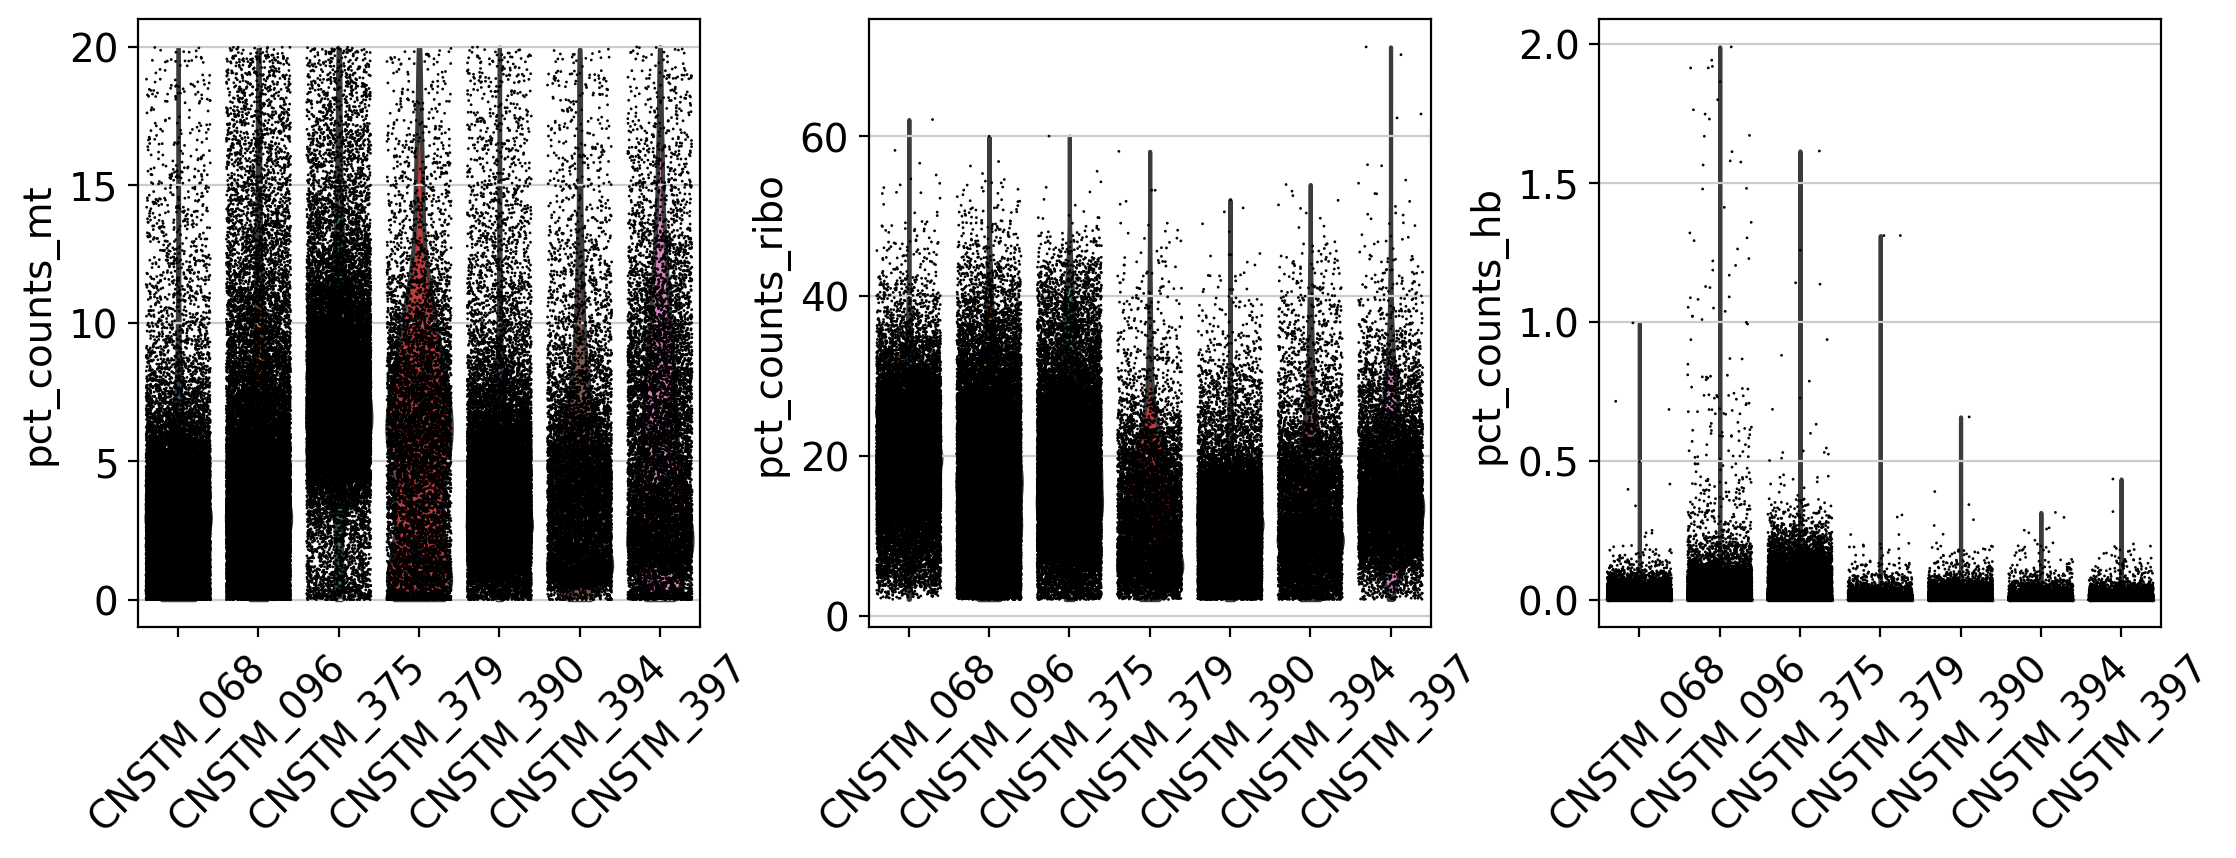

In [36]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [37]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [38]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [39]:
adata = adata[:, ~mito_gene_indicator]

In [40]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

137840 27285
137840 27171


# Calculate cell-cycle scores

In [41]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
90


In [42]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


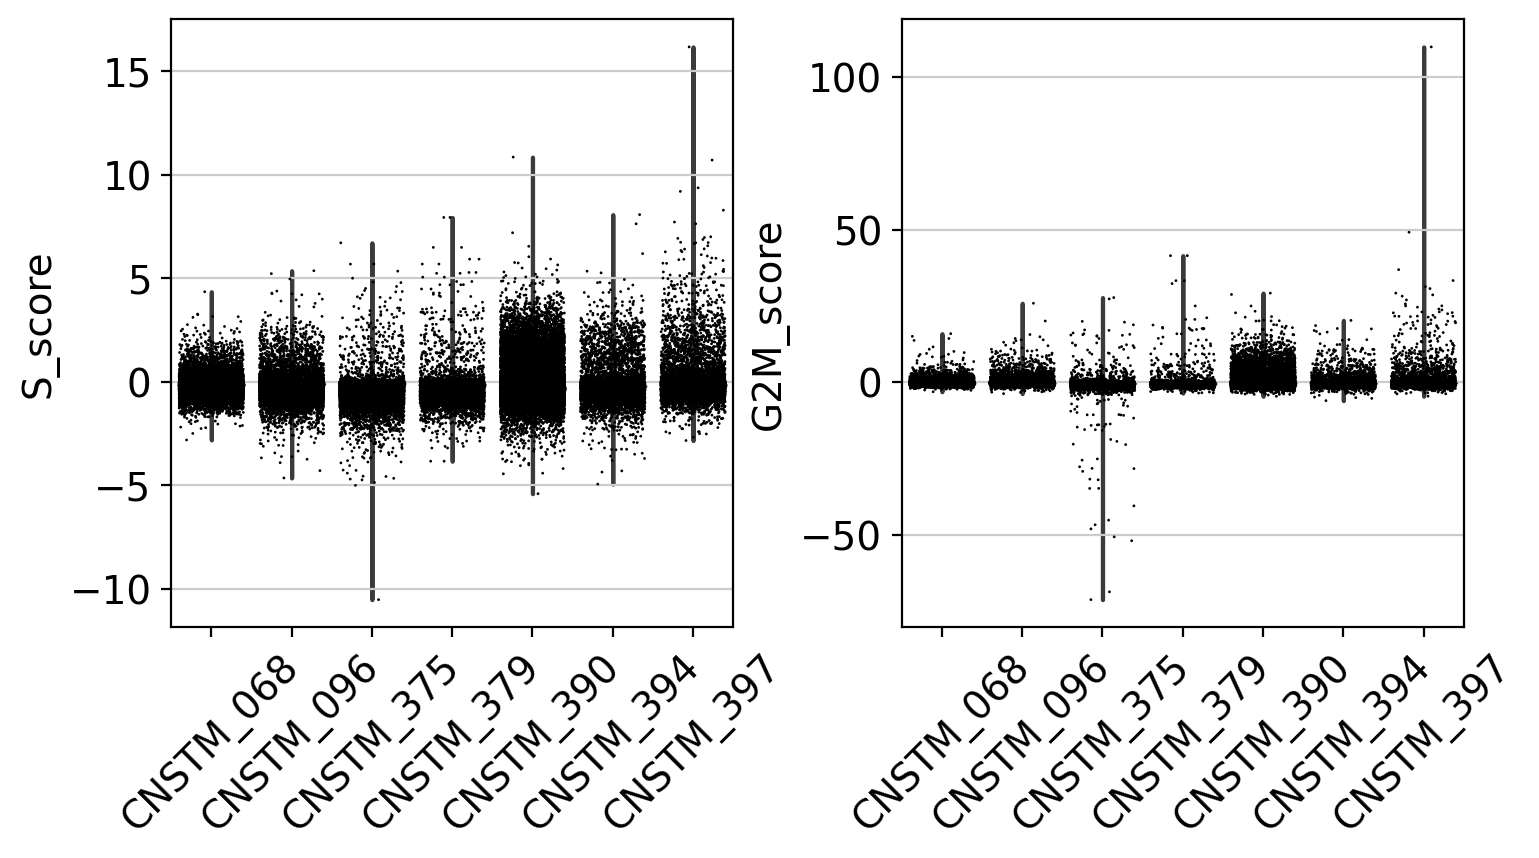

In [43]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.85
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 4.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.1%
Elapsed time: 358.1 seconds


8

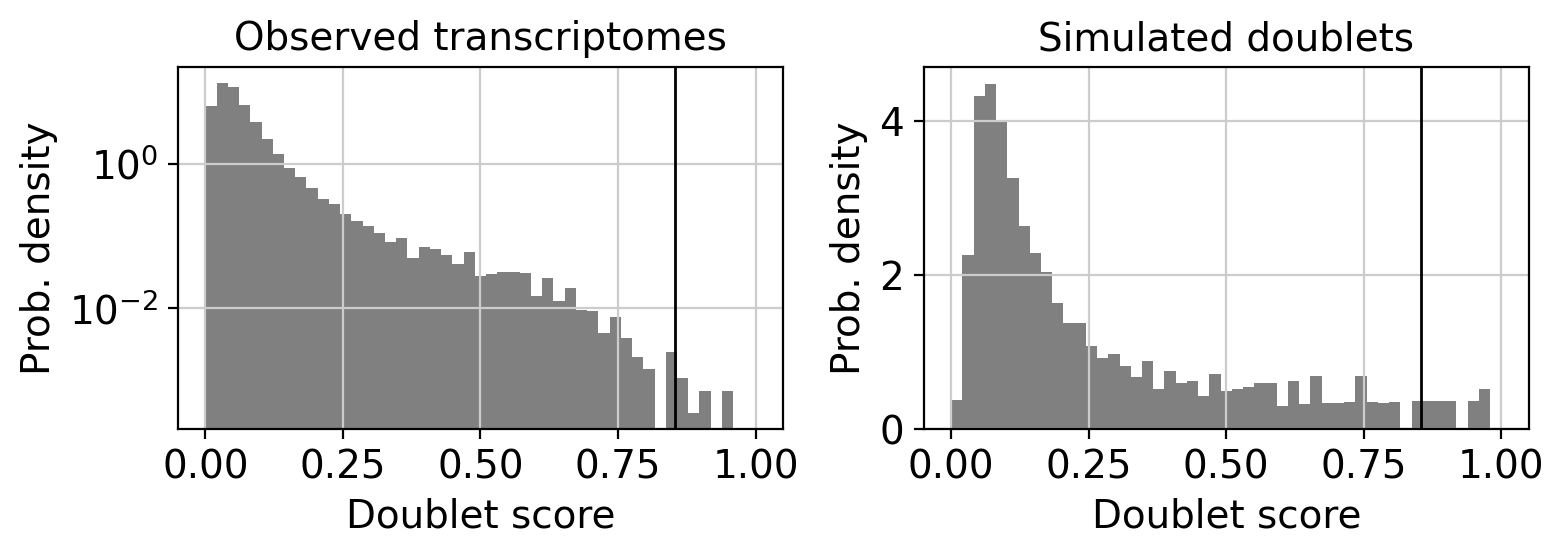

In [44]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [45]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


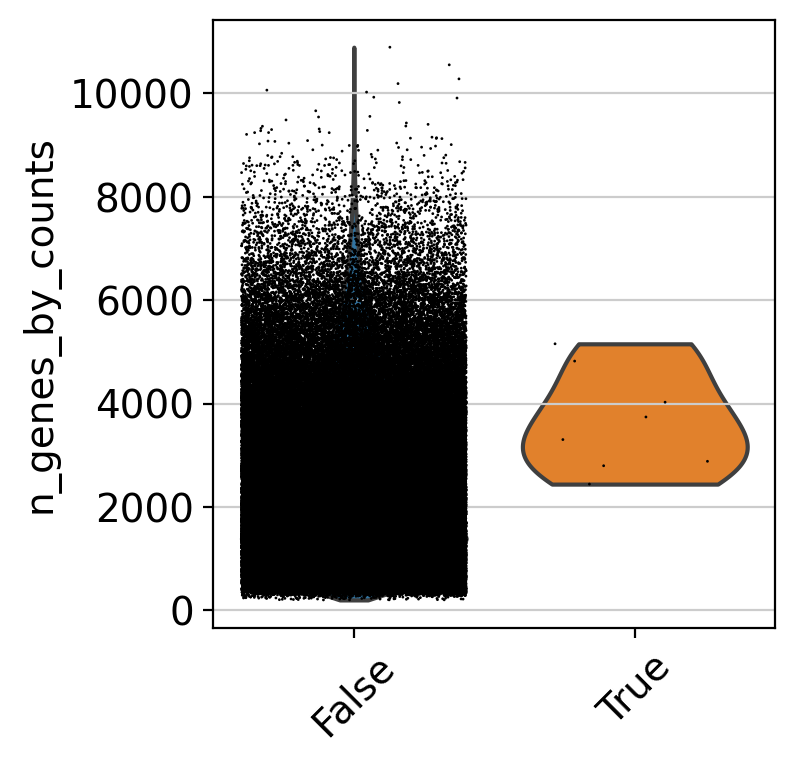

In [46]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [47]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [48]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [49]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [50]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [51]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-14 16:26:36,299 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-14 16:27:24,659 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-14 16:28:12,994 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2022-06-14 16:29:01,383 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2022-06-14 16:29:49,875 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2022-06-14 16:30:38,238 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [52]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [53]:
sc.tl.umap(adata)

In [54]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [55]:
adata

AnnData object with n_obs × n_vars = 137832 × 27171
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-0-5', 'gene_ids-1-5', 'gene_ids-2-5', 'gene_ids-3-5', 'gene_ids-6', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_

In [56]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [57]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [58]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 137832 cells and 27171 genes
🔗 Matching reference genes in the model
🧬 2861 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [59]:
#adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [60]:
adata.obs['Sample'].value_counts()

Patient86    29606
Patient85    28232
Patient89    28180
Patient87    24221
Patient91    10382
Patient90     9462
Patient88     7749
Name: Sample, dtype: int64

In [61]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_O_GSE182109_PMID35140215.h5ad")

In [62]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 137832 × 27171
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-0-5', 'gene_ids-1-5', 'gene_ids-2-5', 'gene_ids-3-5', 'gene_ids-6', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', '

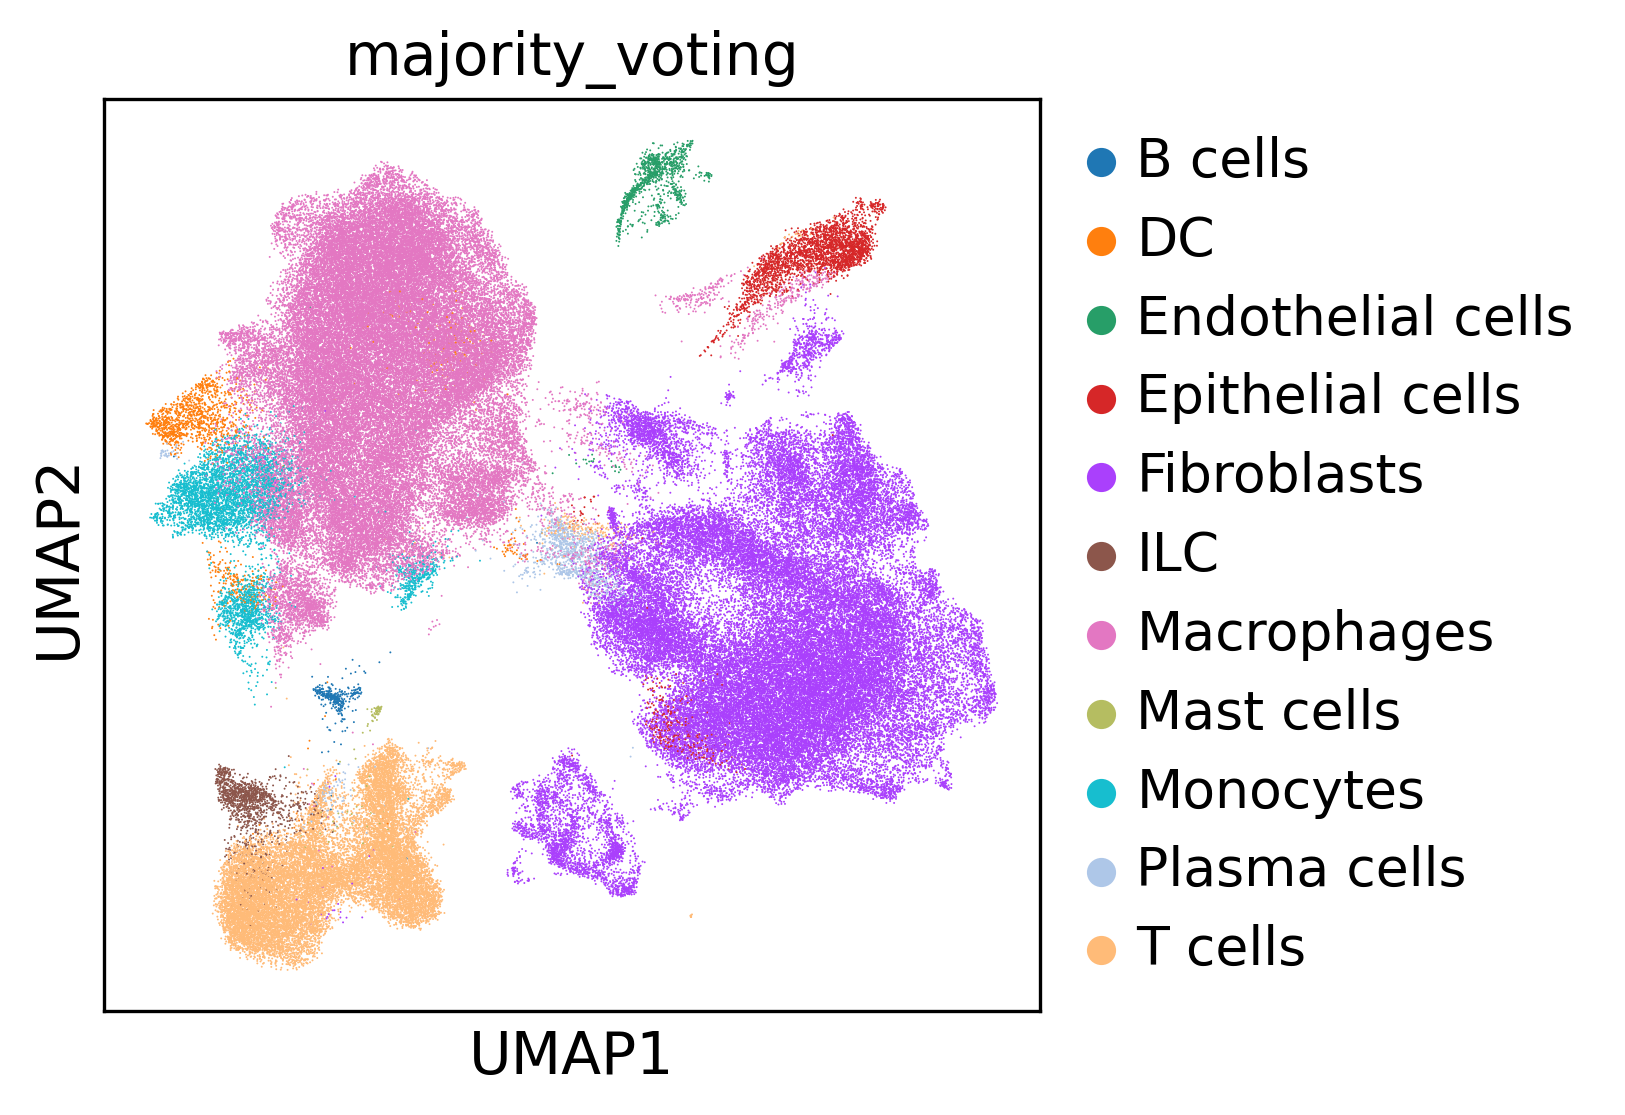

In [63]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [64]:
adata = adata[:, adata.var.highly_variable]

In [66]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [67]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [68]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [69]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

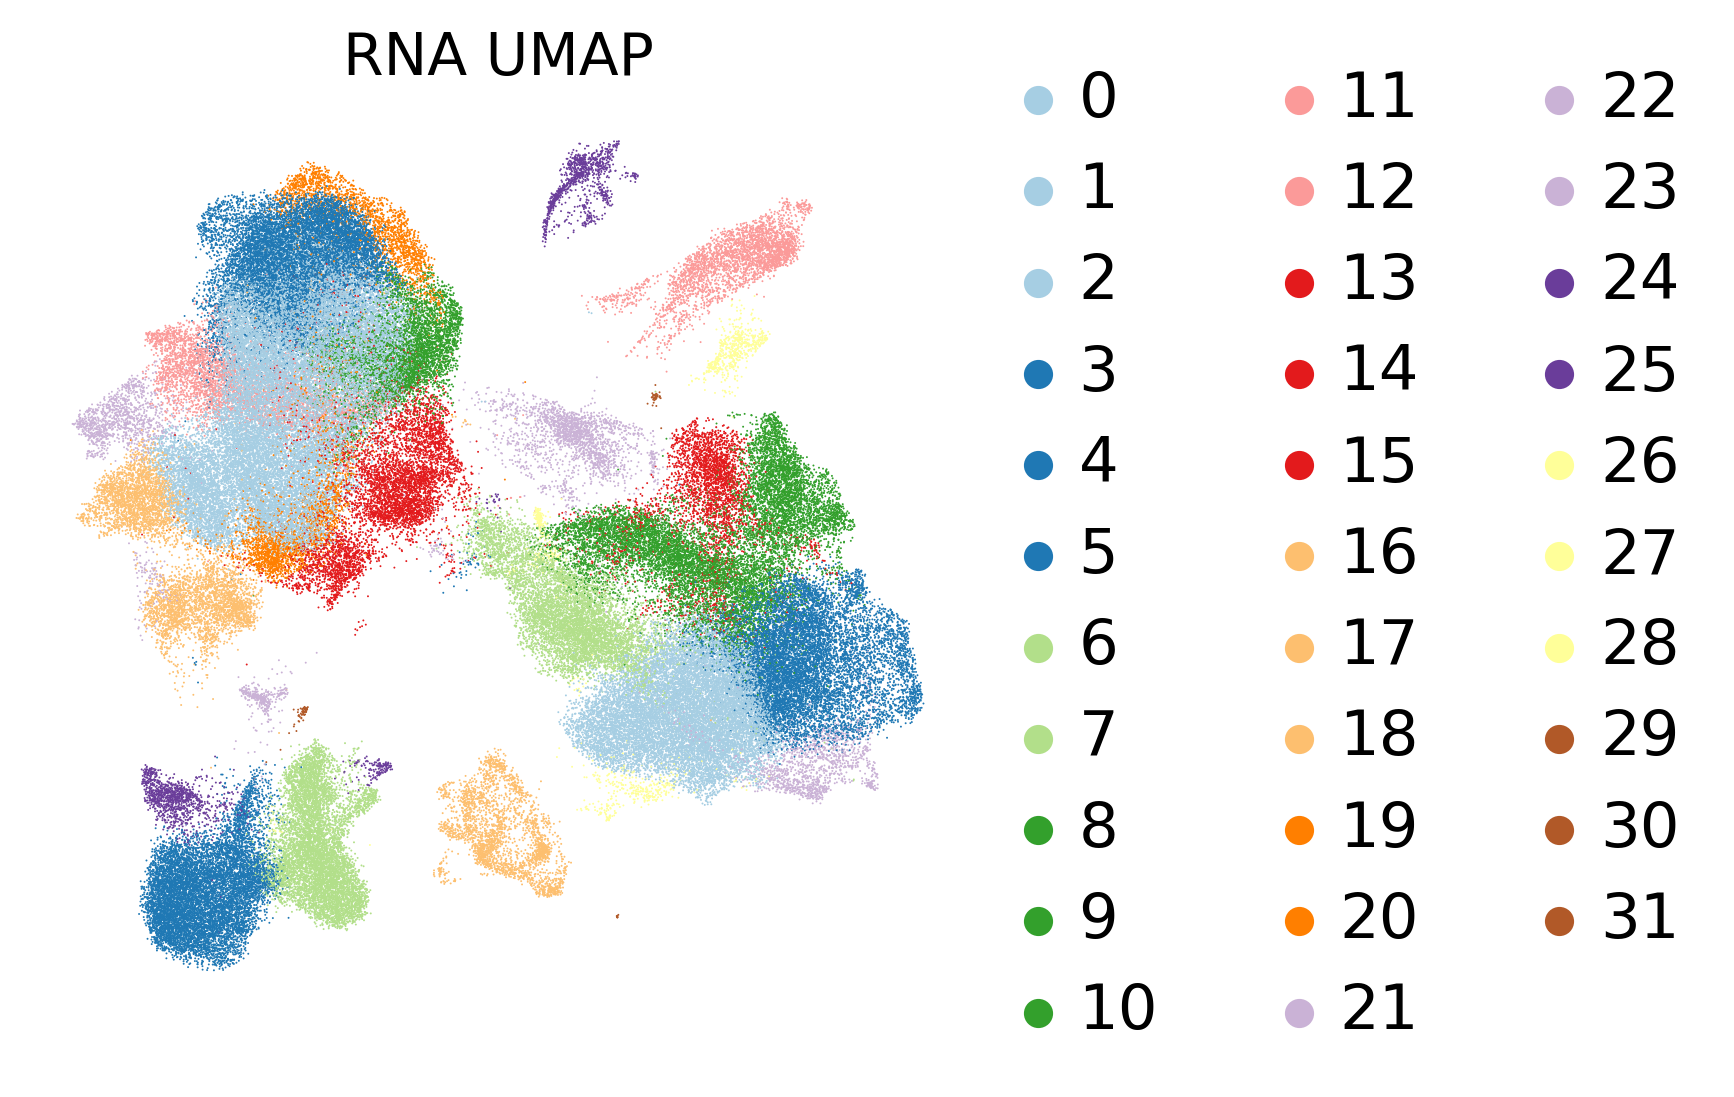

In [70]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [71]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 137832 samples and 2613 targets for 112 sources.


100%|██████████| 137832/137832 [00:47<00:00, 2918.42it/s]


In [72]:
adata.obsm['ora_estimate']

source           Acinar cells  Adipocyte progenitor cells  Adipocytes  \
CNSTM_397_0          1.156437                        -0.0    3.961832   
CNSTM_397_1          2.647272                        -0.0    3.961832   
CNSTM_397_2          1.156437                        -0.0    5.326787   
CNSTM_397_3          1.156437                        -0.0    0.655292   
CNSTM_397_4         -0.000000                        -0.0   -0.000000   
...                       ...                         ...         ...   
CNSTM_068_28704      2.647272                        -0.0    3.961832   
CNSTM_068_28705      1.156437                        -0.0    1.590648   
CNSTM_068_28706      2.647272                        -0.0    2.707875   
CNSTM_068_28707      2.647272                        -0.0    1.590648   
CNSTM_068_28708     -0.000000                        -0.0    1.590648   

source           Alpha cells  Alveolar macrophages  Astrocytes   B cells  \
CNSTM_397_0        -0.000000             -0.000000    3.245334  0.835688   
CNSTM_397_1         1.290534              1.709464    1.936511  1.970872   
CNSTM_397_2         1.290534             -0.000000    7.948757 -0.000000   
CNSTM_397_3         1.290534              1.709464    0.819338  1.970872   
CNSTM_397_4        -0.000000             -0.000000    1.936511  1.970872   
...                      ...                   ...         ...       ...   
CNSTM_068_28704     1.290534             -0.000000    1.936511  1.970872   
CNSTM_068_28705     1.290534             -0.000000    0.819338 -0.000000   
CNSTM_068_28706     1.290534             -0.000000    0.819338  1.970872   
CNSTM_068_28707     1.290534              1.709464   -0.000000  0.835688   
CNSTM_068_28708     1.290534             -0.000000    3.245334  0.835688   

source           B cells memory  B cells naive  Basophils  ...  \
CNSTM_397_0           -0.000000      -0.000000   0.952318  ...   
CNSTM_397_1            1.812499       1.784382   2.215966  ...   
CNSTM_397_2           -0.000000      -0.000000  -0.000000  ...   
CNSTM_397_3            3.052597       3.008914   2.215966  ...   
CNSTM_397_4            1.812499       1.784382  -0.000000  ...   
...                         ...            ...        ...  ...   
CNSTM_068_28704        0.760383       0.747032   0.952318  ...   
CNSTM_068_28705        0.760383       0.747032  -0.000000  ...   
CNSTM_068_28706        1.812499       3.008914   0.952318  ...   
CNSTM_068_28707        1.812499       1.784382   2.215966  ...   
CNSTM_068_28708       -0.000000      -0.000000   0.952318  ...   

source           Smooth muscle cells  Stromal cells    T cells  \
CNSTM_397_0                 1.612291           -0.0   0.635731   
CNSTM_397_1                -0.000000           -0.0   1.549182   
CNSTM_397_2                -0.000000           -0.0  -0.000000   
CNSTM_397_3                -0.000000           -0.0  14.913121   
CNSTM_397_4                -0.000000           -0.0  18.638491   
...                              ...            ...        ...   
CNSTM_068_28704             1.612291           -0.0   0.635731   
CNSTM_068_28705            -0.000000           -0.0  -0.000000   
CNSTM_068_28706            -0.000000           -0.0   1.549182   
CNSTM_068_28707            -0.000000           -0.0   0.635731   
CNSTM_068_28708             1.612291           -0.0   1.549182   

source           T helper cells  T memory cells  T regulatory cells  \
CNSTM_397_0            1.120047       -0.000000           -0.000000   
CNSTM_397_1            1.120047        1.709464           -0.000000   
CNSTM_397_2           -0.000000       -0.000000           -0.000000   
CNSTM_397_3            2.569954        1.709464            1.240785   
CNSTM_397_4           -0.000000        1.709464           -0.000000   
...                         ...             ...                 ...   
CNSTM_068_28704        1.120047        1.709464            1.240785   
CNSTM_068_28705       -0.000000       -0.000000         

In [73]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocyte progenitor cells', 'Adipocytes',
       'Alpha cells', 'Alveolar macrophages', 'Astrocytes', 'B cells',
       'B cells memory', 'B cells naive', 'Basophils',
       ...
       'Smooth muscle cells', 'Stromal cells', 'T cells', 'T helper cells',
       'T memory cells', 'T regulatory cells', 'Tanycytes',
       'Taste receptor cells', 'Thymocytes', 'Tuft cells'],
      dtype='object', name='source', length=112)

In [74]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 137832 × 112
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [75]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Astrocytes   B cells  B cells memory  B cells naive  Basophils  \
0     8.293869  0.053554        0.036671       0.059665   0.210739   
1     1.173674  1.373556        1.497376       1.793261   1.277336   
10    1.656819  1.249541        1.608104       1.748009   1.177771   
11    1.555446  1.431682        1.387068       1.843024   1.384702   
12    2.309827  0.202554        0.070489       0.209194   0.095114   
13    6.858854  0.108204        0.028776       0.044001   0.439848   
14    1.079118  1.291221        1.240503       1.437412   1.027397   
15    1.239663  1.603459        0.810322       0.915949   0.736532   
16    1.459836  3.219928        2.537966       3.335007   2.101092   
17    1.321969  0.291952        0.092774       0.414527   1.597167   
18    1.653816  2.570208        1.253936       1.705625   1.806231   
19    1.159943  1.475932        1.336909       1.512401   1.155897   
2     1.251489  1.597476        1.210914       1.505381   1.577735   
20    1.435135  1.436293        1.478039       1.616089   1.366573   
21    5.781020  0.770965        0.677177       0.869364   1.023641   
22    1.159148  5.526209        5.555414       7.122778   2.311345   
23   13.160417  0.065118        0.038639       0.054270   0.643845   
24    0.839054  3.482411        2.297637       2.130634   1.786757   
25    1.465453  0.598336        0.266925       0.502065   2.518916   
26    6.491421  0.032286        0.006466       0.045524   0.280936   
27    5.957423  2.470953        1.715217       1.875525   1.036289   
28    1.790380  1.169974        0.050599       0.111756   0.122435   
29    0.344643  2.805599        2.191748       3.908676   6.563558   
3     1.663846  1.202300        1.569670       1.700758   1.510902   
30   11.714915  0.293921        0.019497       0.057464   0.748048   
31    3.039546  2.185039        2.473769       4.093972   2.948391   
4    10.563906  0.023657        0.017962       0.048124   0.940955   
5     1.054489  4.295690        3.037545       2.937210   1.750273   
6     1.248901  4.605319        4.019438       4.451210   2.127206   
7     4.712639  0.892139        0.261865       0.282618   0.455199   
8     3.783975  0.181938        0.038612       0.172958   0.397287   
9     7.158543  0.063767        0.020430       0.037609   0.338232   

    Bergmann glia  Dendritic cells  Endothelial cells  Enteric glia cells  \
0        9.927442         1.804632           2.918821            2.527904   
1        1.998235        12.583887           3.494985            0.201683   
10       2.580667        12.064561           2.731994            0.357044   
11       1.908102        14.132594           3.416546            0.446132   
12       1.973814         2.105751           4.575926            1.542520   
13       8.945576         1.721066           3.272798            2.355875   
14       1.384632        12.202013           2.874560            0.167302   
15       2.270270         6.134786           5.914617            0.239752   
16       1.059637        13.874382           2.762051            0.079512   
17       1.471095         1.983411          10.104094            0.151332   
18       0.527591        14.683274           3.610969            0.090885   
19       1.005768        11.549072           3.514377            0.197037   
2        1.042636        13.489216           4.269341            0.160485   
20       2.359543        10.360871           3.113534            0.298947   
21       7.863523         9.426844           4.248824            2.004849   
22       0.844754        15.652546           2.616497            0.515347   
23      17.527061         1.705002           6.365369            3.253815   
24       0.990543         3.403499           1.955542            0.117556   
25       2.015866         2.220654          30.713413            0.093173   
26       6.967607         2.584152           4.107724            2.690530   
27       7.255127         3.823744           2.379943            2.155458   

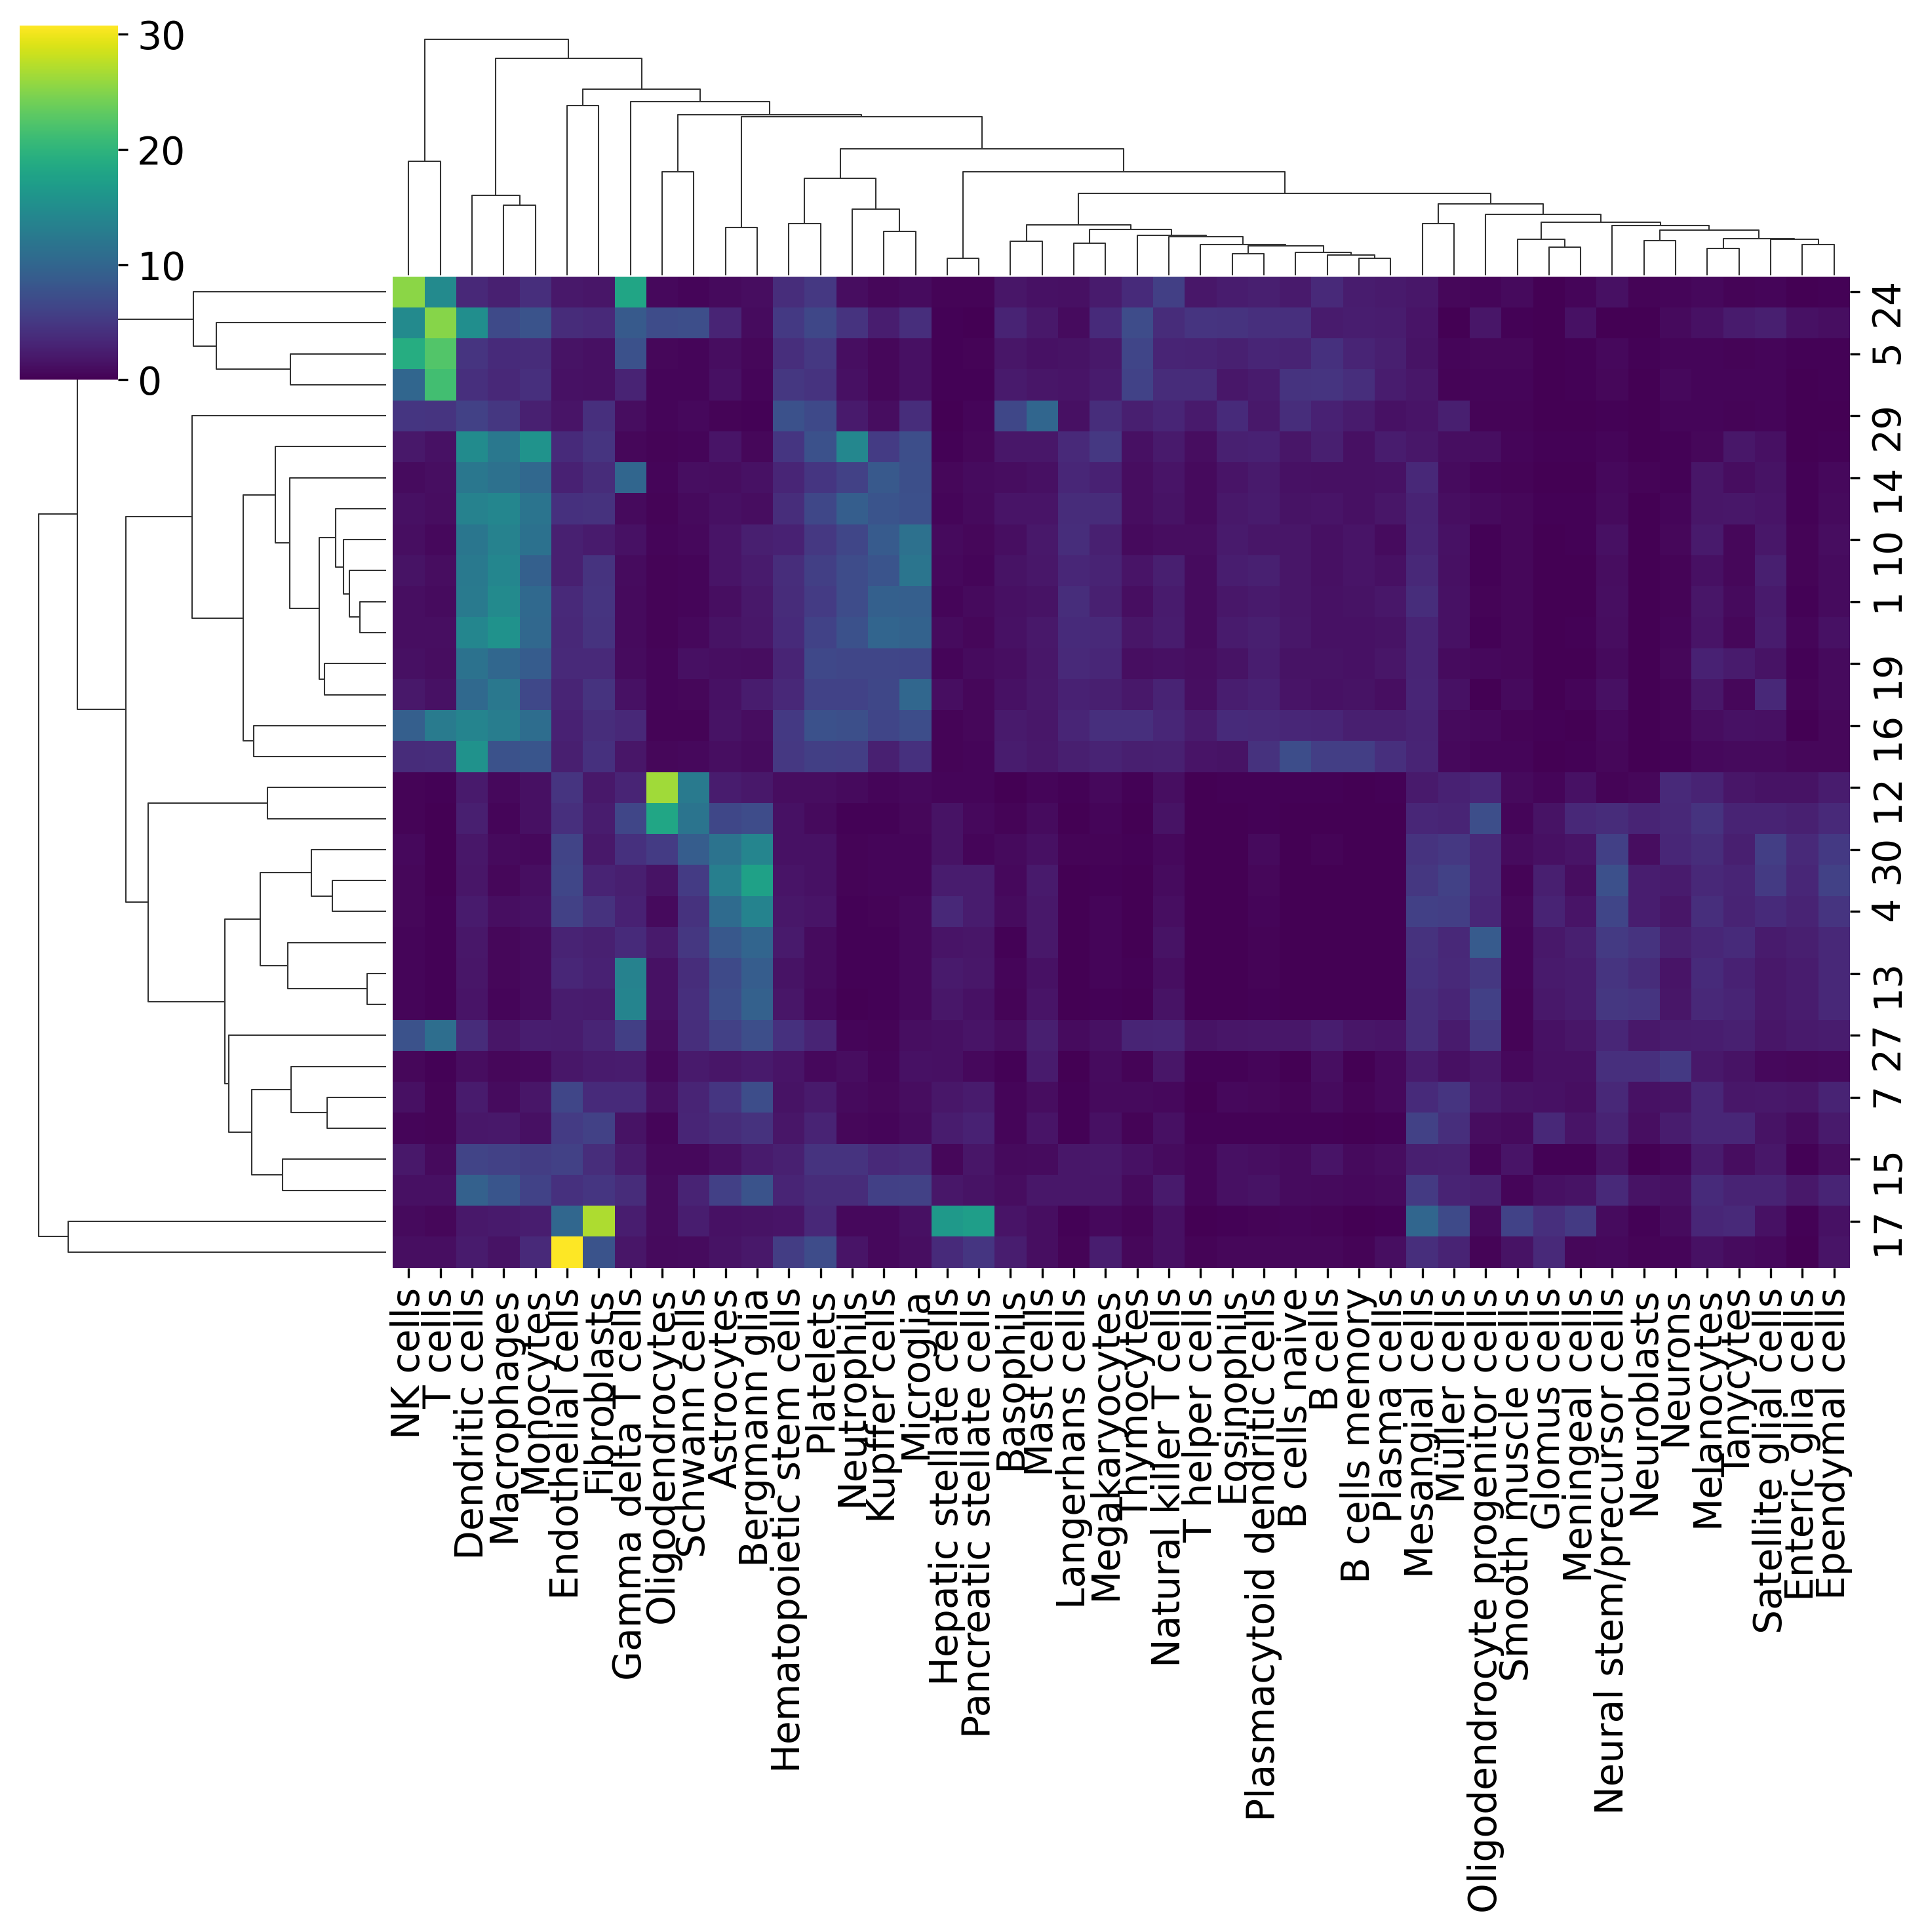

In [76]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [77]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Bergmann glia',
 '1': 'Macrophages',
 '10': 'Macrophages',
 '11': 'Macrophages',
 '12': 'Oligodendrocytes',
 '13': 'Gamma delta T cells',
 '14': 'Dendritic cells',
 '15': 'Dendritic cells',
 '16': 'Dendritic cells',
 '17': 'Fibroblasts',
 '18': 'Monocytes',
 '19': 'Dendritic cells',
 '2': 'Macrophages',
 '20': 'Macrophages',
 '21': 'Dendritic cells',
 '22': 'Dendritic cells',
 '23': 'Bergmann glia',
 '24': 'NK cells',
 '25': 'Endothelial cells',
 '26': 'Oligodendrocytes',
 '27': 'T cells',
 '28': 'Neurons',
 '29': 'Mast cells',
 '3': 'Macrophages',
 '30': 'Bergmann glia',
 '31': 'T cells',
 '4': 'Bergmann glia',
 '5': 'T cells',
 '6': 'T cells',
 '7': 'Bergmann glia',
 '8': 'Fibroblasts',
 '9': 'Gamma delta T cells'}

... storing 'cell_type' as categorical


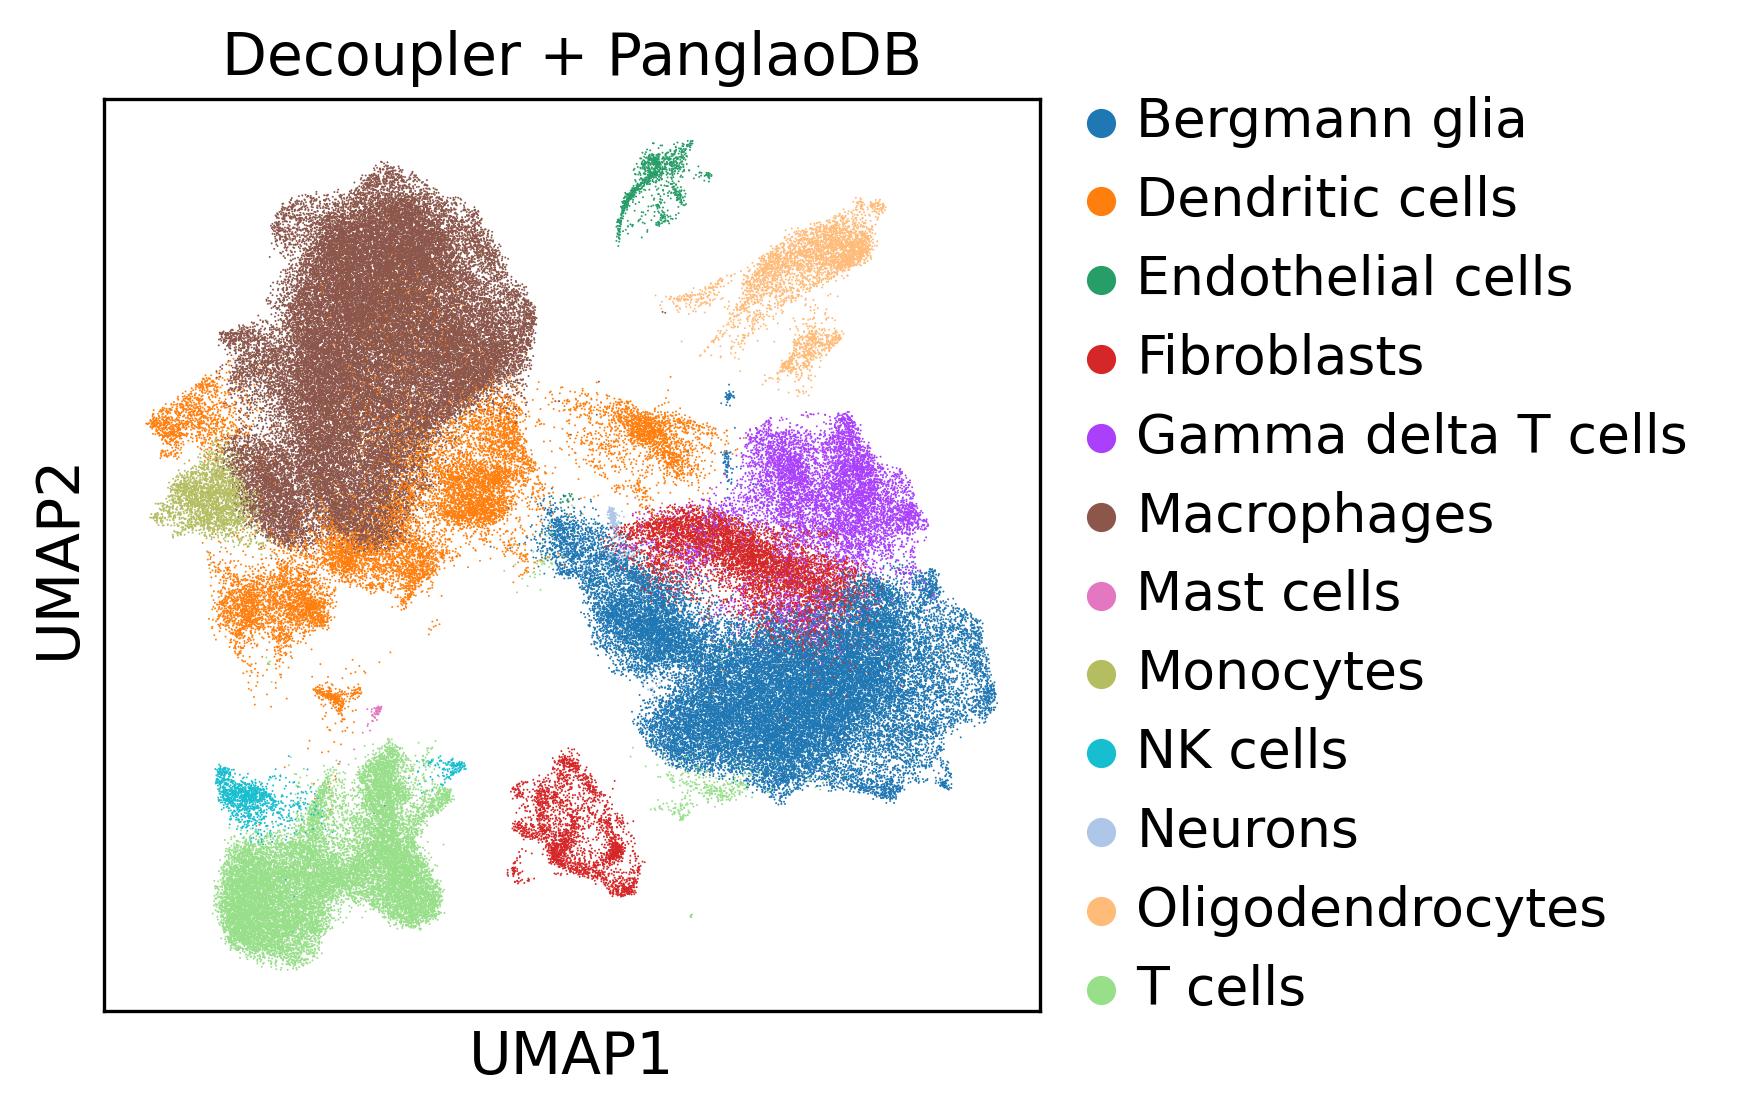

In [78]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [79]:
adata

AnnData object with n_obs × n_vars = 137832 × 2613
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-0-5', 'gene_ids-1-5', 'gene_ids-2-5', 'gene_ids-3-5', 'gene_ids-6', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_in

In [80]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_O_GSE182109_PMID35140215.h5ad")